<a href="https://colab.research.google.com/github/akr81/study_group/blob/main/Velocity/%E3%82%B5%E3%82%A4%E3%82%B3%E3%83%AD%E3%81%A8%E3%82%B3%E3%82%A4%E3%83%B3%E3%81%AE%E5%AE%9F%E9%A8%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
# Google driveをマウント
from google.colab import drive
drive.mount('/content/drive/')
import os
import IPython
base_dir = "/content/drive/MyDrive/Colab Notebooks/Velocity/"
image_dir = os.path.join(base_dir, "./", "image")

def file(filename: str) -> str:
    """base_dir/image下のファイルにアクセスする

    Args:
        filename (str): 対象ファイル名
    
    Returns:
        str: ファイルパス
    """
    return os.path.join(base_dir, filename)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# サイコロとコインの実験
[Velocity](https://www.amazon.co.jp/dp/4478012199)で紹介されていた、ばらつきはあるが平均的にはバランスされたシステムの生産性を検証するゲーム(実験)を再現してみる。

## 基本的なルール
- 6人が並んで座り、左端の人はコイン袋を持つ
- 全員同時にサイコロを振り、出た目の数だけ手持ち在庫のコインを右の人へ渡していく(手持ちが足りない場合は持っているだけすべて)
- (左の人からコインを受け取る)
- 全員がサイコロを振ってコインを動かすまでを1ターン(1日に相当)として、20ターン(1ヶ月)繰り返す

1ヶ月経過後にどれだけのコインが積み上げられるだろうか？  
また、在庫ははどうなっているだろうか？



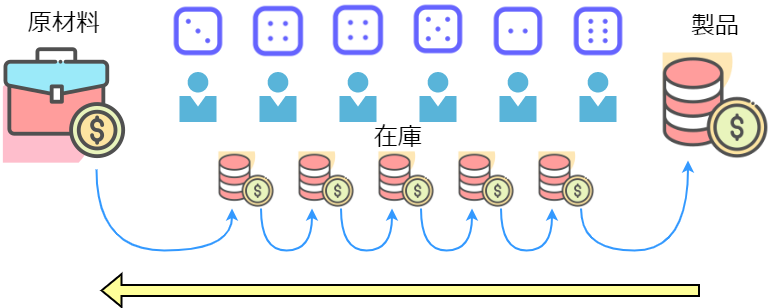

In [ ]:
IPython.display.Image(os.path.join(image_dir, "ゲームルール.drawio.png"), width=640)

## シンプルな予想
サイコロの目の期待値は3.5なので、$3.5 \times 20 = 70$になるのでは？


## 試してみる
1ターン経過ごとにゴールに積み上げられたコインの累積数と、左端の人が投入したコインの累積数を計算し、そこから
- 20ターン経過時にゴールに積み上げられたコインの累積数(生産数に相当)
- 20ターン内で$max(累積投入数-累積積み上げ数)$(在庫の最大値に相当)

を調べてみる

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import typing

%matplotlib inline

def dice(number: int, cheat:bool=False):
    # numberだけサイコロを振って合計値を返す
    sum = 0
    for _ in range(number):
        num = random.randint(1, 6)

        if cheat:
            # チートサイコロでは出目を4-6にする
            if num == 1 or num == 2:
                num = 4
            elif num == 3 or num == 4:
                num = 5
            else:
                num = 6
        sum += num
    return sum

def one_turn(inventories, dices, cheats):
    # 処理の都合上、6人目から順にサイコロを振って動かす形とする
    output = 0
    number_at_bottle_neck = 0
    #print(f"initial inventories: {inventories}")
    for i in reversed(range(6)):
        if dices[i] == 0:
            # サイコロがない場合、ボトルネックと同じ値とする
            number = number_at_bottle_neck
        else:
            number = dice(dices[i], cheats[i])
        # 動かす枚数を決定
        if i == 0:
            move_coins = number
        else:
            move_coins = min(inventories[i], number)
        # 在庫から次の人(最終製品)に渡す
        if i != 0:
            inventories[i] -= move_coins
        if i == 5:
            output = move_coins
        else:
            inventories[i+1] += move_coins
        
        # ボトルネックのサイコロの値を保存
        if i == 3:
            # 4人目がボトルネック
            number_at_bottle_neck = number
        #print(f"dice: {number}, move: {move_coins}, inventory: {inventories}")
    
    return output, inventories

def multi_turn(number_of_turn, initial_inventories, dices, cheats):
    inventories = initial_inventories
    sum_of_done = 0
    max_inventories = 0

    for i in range(number_of_turn):
        done, inventories = one_turn(inventories, dices, cheats)
        sum_of_done += done
        max_inventories = max(max_inventories, sum(inventories))
        #print(f"{i}: done: {done}, sum of done: {sum_of_done}, max inventories: {max_inventories}, inventories: {inventories}")
    
    sum_inventories = sum(inventories)
    return sum_of_done, max_inventories, sum_inventories


In [ ]:
import copy
def run_long_months(months, inventories, dices, cheats):
    sum_of_done_list = []
    max_inventories_list = []
    final_sum_inventories_list = []

    for _ in range(months):
        initial_inventories = copy.deepcopy(inventories)
        sum_of_done, max_inventories, sum_inventories = multi_turn(20, initial_inventories, dices, cheats)
        sum_of_done_list.append(sum_of_done)
        max_inventories_list.append(max_inventories)
        final_sum_inventories_list.append(sum_inventories)

    np_sum_of_done_list = np.array(sum_of_done_list)
    np_max_inventories_list = np.array(max_inventories_list)
    np_final_sum_inventories_list = np.array(final_sum_inventories_list)
    print(f"For output: mean: {np_sum_of_done_list.mean()}, std: {np_sum_of_done_list.std()}")
    print(f"For max inventories: mean: {np_max_inventories_list.mean()}, std: {np_max_inventories_list.std()}")
    print(f"For final inventories: mean: {np_final_sum_inventories_list.mean()}, std: {np_final_sum_inventories_list.std()}")

    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.hist(sum_of_done_list, 50)
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.hist(max_inventories_list, 50)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.hist(final_sum_inventories_list, 50)

### 動作確認

In [ ]:
# 1ターンだけ実行してみる
# 全員が4枚持った状態でスタート
done, inventories = one_turn([0,4,4,4,4,4], [1,1,1,1,1,1], [False, False, False, False, False, False])
print(done, inventories)

2 [0, 1, 4, 7, 1, 6]


In [ ]:
# 20ターン実行
# 全員が4枚持った状態でスタート
sum_of_done, max_inventories, inventories = multi_turn(20, [4,4,4,4,4,4], [1,1,1,1,1,1], [False, False, False, False, False, False])

## 実験(1): 平均的にはバランスが取れている場合
20ターン(1ヶ月)でどれだけのコインをゴールまで運べるかと、期間内の最大の在庫数、完了時の在庫数がどうなるかを確認する。  
初期条件として、1人目(コインを取り出す人)以外は4枚のコインを在庫として持つものとする。  
5000ヶ月実行し、月ごとの分布を見てみる。


For output: mean: 54.1244, std: 4.1735026824000006
For max inventories: mean: 38.0746, std: 7.312142971796982
For final inventories: mean: 36.0518, std: 8.19401713202993


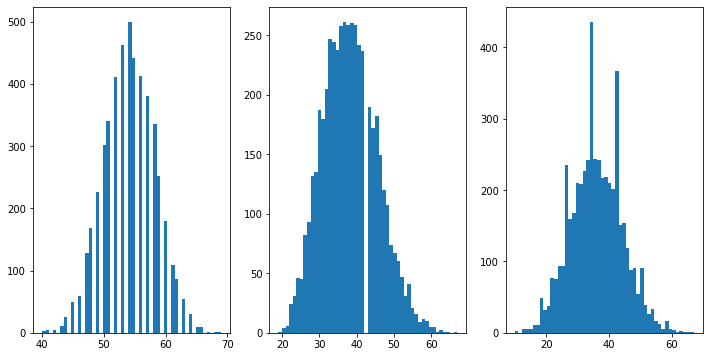

In [ ]:
# 5000ヶ月分実行
inventories = [0, 4, 4, 4, 4, 4]
dices = [1, 1, 1, 1, 1, 1]
cheats = [False, False, False, False, False, False]
run_long_months(5000, inventories, dices, cheats)


まず完了した製品の数については、おおよそ正規分布のような形状で平均完了数が～54、標準偏差が～4.2になる。  
(当初の期待値を70とするとそれは～$3.8\sigma$に相当し、ほぼ起こらないことがわかる)

1ヶ月の間の最大在庫数は40弱となった。  
これは、初期在庫(20)の倍に相当する。

In [ ]:
# 70までの累積を計算
norm.cdf(x=70.0, loc=np_sum_of_done_list.mean(), scale=np_sum_of_done_list.std())

0.9999342612503647

In [ ]:
# 参考
# 上位何%にあたるかを標準正規分布の累積分布関数で計算
# ±1σは～68%なので、1σを累積分布で計算すると片側16%を引いた84%くらいになるはず
1 - norm.cdf(x=1.0, loc=0, scale=1.0)

0.15865525393145707

## 実験(2): 1ヶ所にアンバランスなポイントを作った場合
意図的に4人目がボトルネックになるよう、他の人が振るサイコロの数を2個にする。  
この場合、完了数と最大在庫はどうなるだろうか？

For output: mean: 69.1736, std: 6.79531184273393
For max inventories: mean: 91.1116, std: 12.47778607926903
For final inventories: mean: 90.9004, std: 12.570428785049458


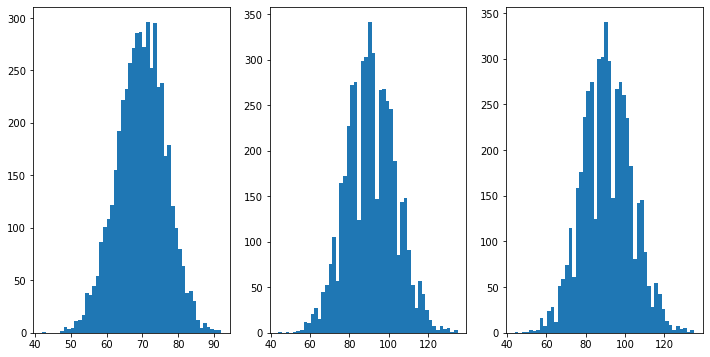

In [ ]:
inventories = [0, 4, 4, 4, 4, 4]
dices = [2, 2, 2, 1, 2, 2]
cheats = [False, False, False, False, False, False]
run_long_months(5000, inventories, dices, cheats)


この条件では完了した製品の数は～70であり、当初の期待値に近い結果となった。  
一方、期間内の最大在庫数は90で初期在庫の4.5倍、実験(1)の条件と比べても2倍以上となっている。

## 実験(3): (2)+ボトルネックに在庫多め+原材料の投入量をボトルネックに揃える
実験(2)の条件に加え、ボトルネック部分の初期在庫を3倍の12にする。  
さらに、原材料の投入量をボトルネックの値に揃える。

For output: mean: 70.5364, std: 7.163649561501456
For max inventories: mean: 31.8166, std: 1.5926595493073843
For final inventories: mean: 27.4296, std: 2.632611600673369


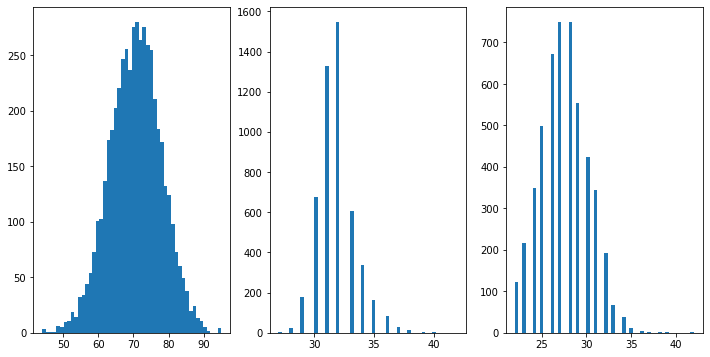

In [ ]:
inventories = [0, 4, 4, 12, 4, 4] # ボトルネックの初期在庫3倍
dices = [0, 2, 2, 1, 2, 2] # 1人目はサイコロを振らず、ボトルネックの値をそのまま使用する
cheats = [False, False, False, False, False, False]
run_long_months(5000, inventories, dices, cheats)


この条件では、完了した製品の数は実験(2)とほとんど変わっていない。  
だが、在庫が初期(28)からほとんど増えていない。

## 実験(4): (3)+ボトルネックのサイコロに細工する
ボトルネックのサイコロの出目を4-6に限定する。

For output: mean: 96.1832, std: 3.5439014884728386
For max inventories: mean: 35.0288, std: 2.2359719497346116
For final inventories: mean: 31.8598, std: 2.513034810741785


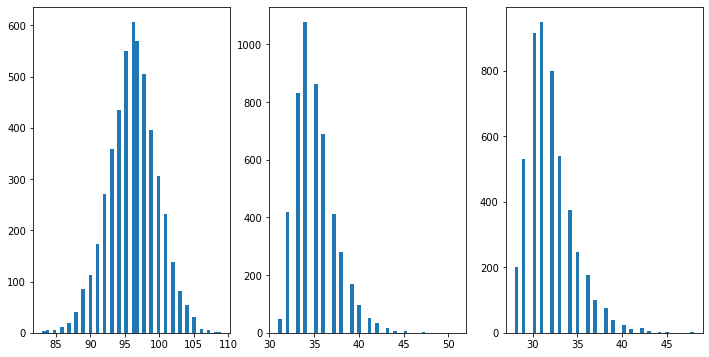

In [ ]:
inventories = [0, 4, 4, 12, 4, 4] # ボトルネックの在庫3倍
dices = [0, 2, 2, 1, 2, 2] # 1人目はサイコロを振らない
cheats = [False, False, False, True, False, False] # ボトルネックは細工したサイコロ
run_long_months(5000, inventories, dices, cheats)

この条件では、完了した製品の数が実験(3)から大きく増加し、しかも在庫が初期(28)からほとんど増えていない。

## まとめと考察
### 各実験の条件で何が実現されたか

実験(1)-(4)をまとめると、以下のようになる。

| 実験 | 条件 | 生産量 | 在庫量 |
| ---- | ---- | ------ | ------ |
| (1) | バランスが取れたライン | 小 | 小 |
| (2) | アンバランスなライン | 大 | 大 |
| (3) | アンバランス+ボトルネックに従うライン | 大 | 小 |
| (4) | アンバランス+増強したボトルネックに従うライン | 最大 | 小 |

(1)は平均的にはバランスされているが、その時々によってボトルネックが変化し、全体としての能力が制限されてしまっている状態。

(2)は敢えてボトルネックを作った上で、ボトルネックを100%活用するためにそれ以外がフル回転する状態。  
もちろん生産量はボトルネックの能力に比例して向上するが、ボトルネックの能力以上に前工程が動いてしまうと、在庫がどんどん増えていってしまう。

(3)は、ボトルネックが100%活用できる数に合わせて全体が回転する状態。  
ボトルネックが必要とする以上に前工程が動くことはなく、後工程はボトルネックに従うため、在庫が増えることはない。

(4)は、ボトルネックをパワーアップした状態。  
パワーアップしてはいるが、期待値としてはボトルネックの5に対してサイコロ2つの他工程は7であり、まだ余力を残している。

### 期待値を増やす方法の違い

ボトルネックのパワーアップをサイコロを増やすことで達成しようとすると、(1)の状態に戻ってしまう。  
なお、「サイコロを増やす」ことと、「サイコロに細工する」は出目の期待値を増やすという期待は同じだが、その意味合いは大きく異なる。

|実験における条件|期待する成果|実現する方法|コスト|
|---|---|---|---|
|サイコロを増やす|生産量をアップ(生産能力を上げる)|人や機械を増やす|高|
|サイコロに細工する|生産量をアップ(歩留まりをよくする)|教育・何らかのカイゼン|低|

どの工程がボトルネックであるかが分かっているのであれば、そこに集中してカイゼンを行うことで、**すべてをカイゼンすることなくすべてが改善される**。  
また、敢えてボトルネックをデザインすることで、全体をコントロールすることができる。

### スループットはどうなった？
投入したコストと、1ヶ月で得られた利益を考えてみる。  
ここでは、以下のようにおく。

| 項目 | コスト/売上 |
| ---- | ---- |
| 原材料 | 1万円/個 |
| サイコロ | 10万円/個 |
| 製品 | 3万円/個 |

各条件の売上とコストから、利益を計算する。  
なお、ここでは生産した製品はすべて売れたものとし、在庫は売上に変わっていないコストとみなす。

| 条件 | 全サイコロ数 | 投入原材料数 | 在庫数 | 生産製品数 | 売上 - 総コスト | 利益 | 
| ---- | ---- | ------ | ------ | ---- | ---- | ---- |
| (1) | 6      | 90  | 36 | 54 | 54\*3 - (90 + 6\*10)   | 12 |
| (2) | 11     | 160 | 91 | 69 | 69\*3 - (160 + 11\*10) | -63 |
| (3) | 11(10) | 98  | 27 | 71 | 71\*3 - (98 + 11\*10)  | 5(15) |
| (4) | 11(10) | 128 | 32 | 96 | 96\*3 - (128 + 11\*10) | 50(60) |

(*)条件(3),(4)では、1人目に相当するサイコロを数に含めるかどうかによって分けている。

また、各条件での生産効率($生産製品数/投入原材料数$)は以下の通り。

| 条件 | 生産効率 |
| ---- | ---- |
| (1) | 54/90 = 0.6 |
| (2) | 69/160 = 0.43 |
| (3) | 71/98 = 0.72 |
| (4) | 96/128 = 0.75 |

(3), (4)の生産効率に大差はないが、同じ期間内の生産量に違いがあるため、利益には大きな差が出ている。

### (備考)5段階集中ステップとの対応
もはや自明ではあるが、この実験はTOCの5段階集中ステップに対応している。
1. 制約を見つける → 実験(2)で制約を作っている
1. 制約を徹底活用する方法を決める → 実験(3)において、初期条件として制約に在庫を多くしている
1. 他の全てを②の決定に従わせる → 実験(3)において、最上流の工程を制約と協調させている
1. 制約の能力を高める → 実験(4)において、サイコロに細工している
1. ここまでのステップで制約が解消したら1.に戻る
